In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
import random
import os
from qmplot import manhattanplot, qqplot
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings("ignore")

# phenotypes

In [17]:
pheno = pd.read_csv("all_phenotypes_binary/phecodes/aj/pcs/regenie/phecodes_all_pcs_phen.txt", sep="\t")

In [18]:
pheno_counts = pheno.iloc[:, 3:].apply(lambda col: col[col == 2].count()).to_frame(name="count")

In [19]:
# pheno_counts[(pheno_counts["count"] > 9) & (pheno_counts["count"] < 11 )]

In [65]:
for num_of_twos in [61]:
    list_length = len(pheno)
    
    for i in range(1002, 3001): 
        lst = [2] * num_of_twos + [1] * (list_length - num_of_twos)
        random.shuffle(lst)
        sample_df = pheno.iloc[:, :3].join(pd.DataFrame(lst, columns=["pheno"]))
        
        sample_df.to_csv(f"all_phenotypes_binary/phecodes/aj/permutation_test/pheno/pheno{num_of_twos}/pheno{i}.txt", index=False, sep="\t")


In [32]:
# for i in range(501, 1000): 
#     sample_df = pheno.iloc[:, 3:].sample(frac=1)
#     sample_df = sample_df.reset_index()
#     sample_df = pheno.iloc[:, :3].join(sample_df)
#     sample_df.to_csv(f"all_phenotypes_binary/phecodes/pr/permutation_test/pheno/pheno{i}.txt", sep="\t", index=False)

# simulated results

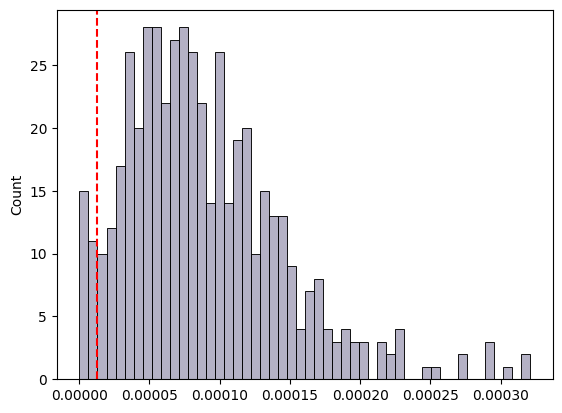

10 1.2373711899353532e-05


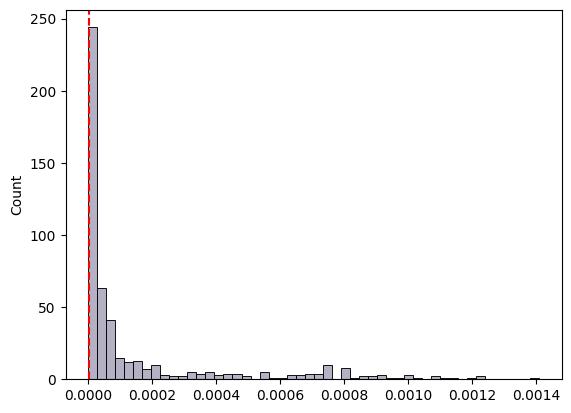

50 4.018278188544582e-06


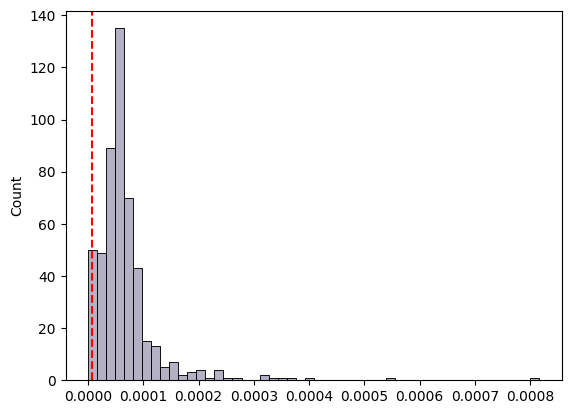

100 6.421404085235438e-06


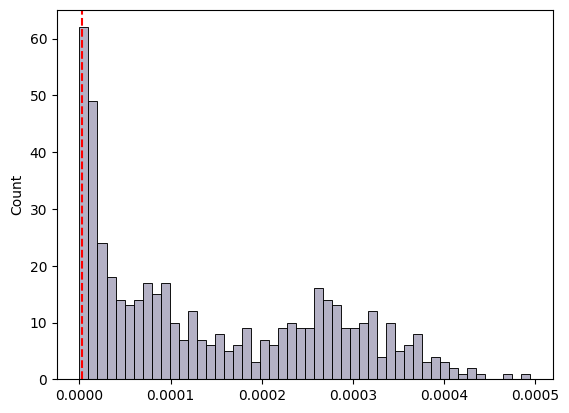

200 2.920855014605006e-06


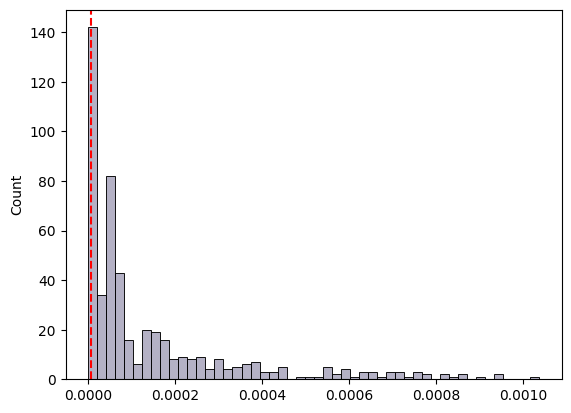

300 7.147102326055093e-06


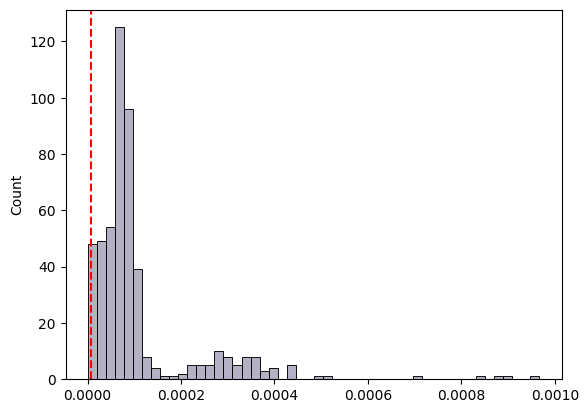

500 7.225701225133499e-06


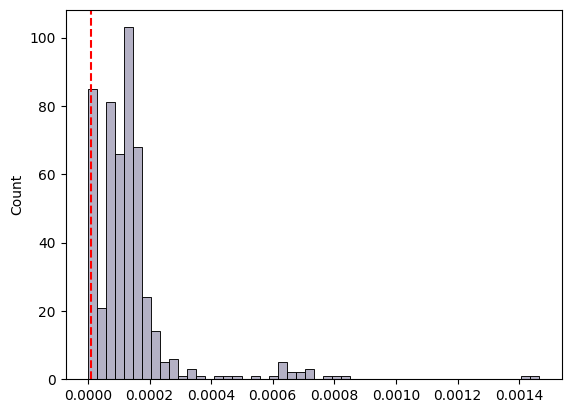

600 1.1070060643056212e-05


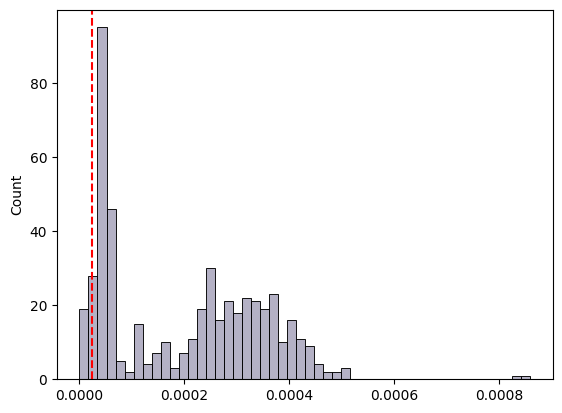

800 2.5276096222944438e-05


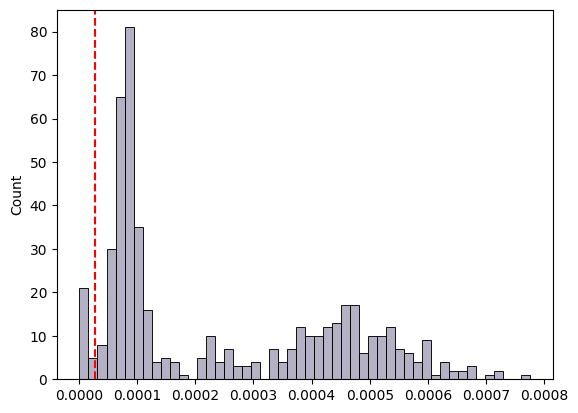

900 2.7458069503489044e-05


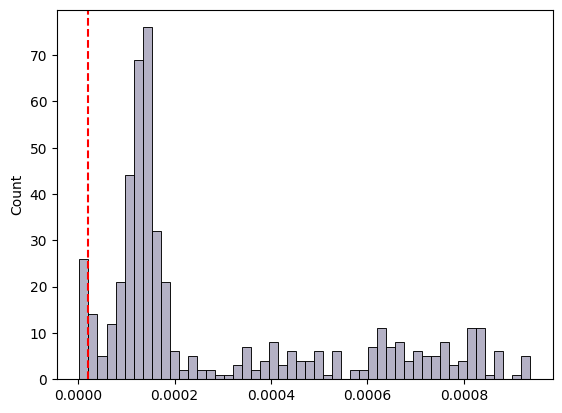

1000 2.1098909047772584e-05


In [152]:
threshold_values = []
sample_sizes = [10, 50, 100, 200, 300, 500, 600, 800, 900, 1000]
pop="aj"
for i in sample_sizes: 
    sig = pd.read_csv(f"all_phenotypes_binary/phecodes/{pop}/permutation_test/results/pheno{i}_pvalues.csv")
    
    min_p_values_per_permutation = np.nanmin(sig.values.T, axis=0)

    sorted_min_p_values = np.sort(min_p_values_per_permutation)

    alpha = 0.05
    threshold_index = int((alpha) * len(sorted_min_p_values))
    
    significance_threshold = sorted_min_p_values[threshold_index]
    threshold_values.append(significance_threshold)
    
    sns.histplot(x=min_p_values_per_permutation, bins=50, color="#9B97B2")
    plt.axvline(x=significance_threshold, linestyle="--", color="red") 
    plt.show()
    
    print(i, significance_threshold)

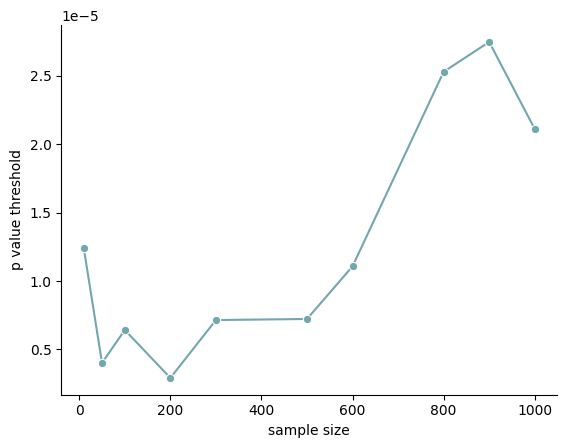

In [153]:
sns.lineplot(x=sample_sizes, y=threshold_values, color="#73A6AD", marker="o")
plt.xlabel("sample size")
plt.ylabel("p value threshold")
sns.despine()
plt.show()

# reclassified 

In [145]:
pheno = pd.read_csv("all_phenotypes_binary/phecodes/pr/updated/phecodes_all_pcs_phen.txt", sep="\t")
pheno_counts = pheno.iloc[:, 3:].apply(lambda col: col[col == 2].count()).to_frame(name="count")

In [146]:
phenos = pheno_counts[(pheno_counts["count"] >= 10) &  (pheno_counts["count"] < 20)].index

In [147]:
cliques = pd.read_csv("icurl/libd_updated/pr/min_hom_cliques.txt", sep="\t")["SNP"].values

In [149]:
pop = "pr"

fdr5 = 0 
fdr10 = 0 
perm = 0 

difference = []
directory = f"all_phenotypes_binary/phecodes/{pop}/updated/icurl/"

for p in phenos: 
    
    file = f"{directory}{pop}_{p}_combined.regenie"

    if os.path.isfile(file): 
        assoc = pd.read_csv(file, sep=" ")
        assoc = assoc[assoc["ID"].isin(cliques)]
        assoc["p"] = 10**(-assoc[f"LOG10P.Y1"])

        assoc["fdr_5"] = multipletests(assoc["p"], method="fdr_bh", alpha=0.05)[0]
        assoc["fdr_10"] = multipletests(assoc["p"], method="fdr_bh", alpha=0.1)[0]
        assoc["perm"] = np.where(assoc["p"] < 2.9034877629893804e-05, True, False)

        fdr5 += len(assoc[assoc["fdr_5"] == True])
        fdr10 += len(assoc[assoc["fdr_10"] == True])
        perm += len(assoc[assoc["perm"] == True])
        
        if len(assoc[assoc["fdr_10"] == True])-len(assoc[assoc["perm"] == True]) < 0: 
            print(file, len(assoc[assoc["fdr_10"] == True])-len(assoc[assoc["perm"] == True]))

        difference.append(len(assoc[assoc["fdr_10"] == True])-len(assoc[assoc["perm"] == True]))

all_phenotypes_binary/phecodes/pr/updated/icurl/pr_NS_349.14_combined.regenie -2
all_phenotypes_binary/phecodes/pr/updated/icurl/pr_SO_366.21_combined.regenie -2


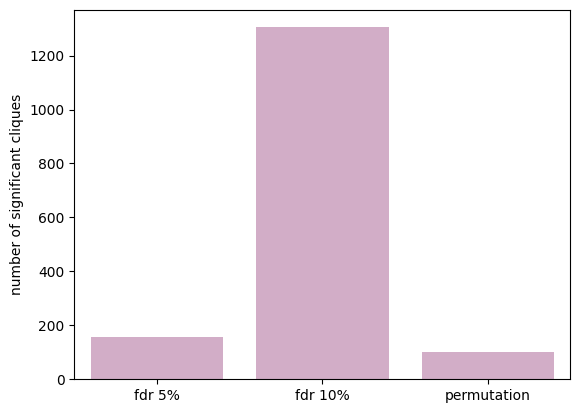

In [133]:
sns.barplot(y=[fdr5, fdr10, perm], x=["fdr 5%", "fdr 10%", "permutation"], color="#D8A7CA")
plt.ylabel("number of significant cliques")
plt.show()

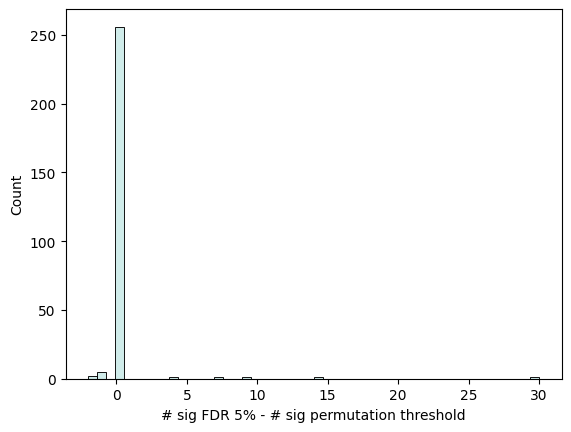

In [134]:
sns.histplot(x=difference, bins=50, color="#C1E6E3")
plt.xlabel("# sig FDR 5% - # sig permutation threshold")
plt.show()


In [150]:
df = pd.DataFrame(difference)
no_change = len(df[df[0] == 0])
more_perm = len(df[df[0] < 0])
more_fdr = len(df[df[0] > 0])

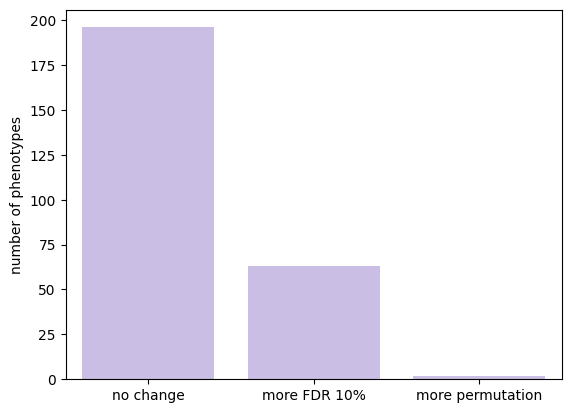

In [151]:
sns.barplot(x=["no change", "more FDR 10%", "more permutation"],
            y=[no_change, more_fdr, more_perm], color="#C7B8EA")
plt.ylabel("number of phenotypes")
plt.show()

# empirical p val trait results

In [41]:
perm = pd.read_csv("all_phenotypes_binary/phecodes/aj/permutation_test/results/aj_CM_761_permutation_combined.regenie", sep=" ")

In [42]:
# sig = pd.read_csv("all_phenotypes_binary/phecodes/aj/permutation_test/results/pheno61_MS_723.51_pvalues.csv")

In [43]:
perm["empirical pval"] = np.where(perm["empirical pval"] == 0, 0.05/3000, perm["empirical pval"])

In [44]:
perm["-log P"] = -(np.log10(perm["empirical pval"]))
perm["-log P original"] = -(np.log10(perm["p"]))

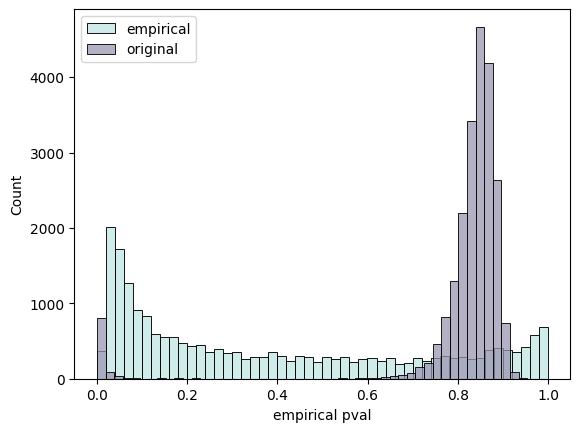

In [45]:
sns.histplot(x="empirical pval", data=perm, bins=50, label="empirical", color="#C1E6E3")
sns.histplot(x="p", data=perm, bins=50, label="original", color="#9B97B2")
plt.legend()
plt.show()

In [46]:
# qqplot(data=perm["empirical pval"], color="#73A6AD", alpha=1)
# sns.despine()
# plt.show()

In [47]:
perm["fdr"] = multipletests(perm["empirical pval"], method="fdr_bh", alpha=0.05)[0]

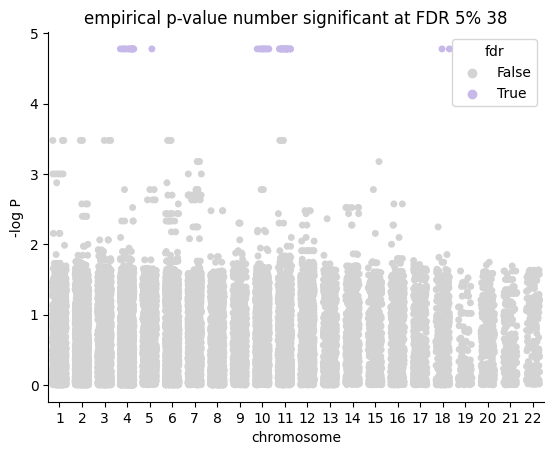

In [48]:
order = [str(i) for i in range(1, 23)]
bonf_line = -np.log10(0.05/len(perm))

sns.stripplot(x="CHROM", y="-log P", data=perm, order=order, hue="fdr", jitter=0.3, 
               palette=sns.color_palette(["lightgrey", "#C7B8EA"]*11))

num_sig = len(perm[perm["fdr"] == True])
plt.title(f"empirical p-value number significant at FDR 5% {num_sig}")

# plt.axhline(y=bonf_line, linestyle="--", color="lightgrey") 
plt.xlabel("chromosome")
sns.despine()
plt.show()

In [34]:
perm["fdr"] = multipletests(perm["empirical pval"], method="fdr_bh", alpha=0.05)[0]

In [35]:
len(perm[perm["fdr"] == True])

10